In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
import random

GRID_SIZE = 30
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]
N_ACTIONS = 5
ALPHA = 0.3
GAMMA = 0.85
EPSILON_INITIAL = 0.3  # Alto para exploración inicial
EPSILON_MIN = 0.05  # Mínimo para explotación
DECAY_RATE = 0.001  # Baja gradual (ajusta: más alto = decay más rápido)
PATIENCE = 35000  # Early stopping: Para si no mejora 
MAX_STEPS = 400
EPISODIOS = 70001
# Nuevo: Params para composiciones automáticas (meta-RL)
COMP_GRID_SIZE = 60  # Lienzo grande para composiciones
RECETAS = {  # Recetas (nombre → lista figuras, 2-3 máx)
    'casa': ['cuadrado_borde', 'triangulo_borde'],
    'arbol': ['rectangulo_borde', 'circulo_borde'],
    'puerta': ['rectangulo_borde', 'linea_borde']
}
print("Setup listo con recetas para composiciones.")

Setup listo con recetas para composiciones.


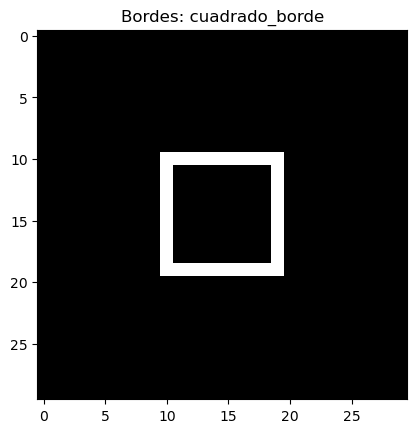

Figura actual: cuadrado_borde


In [34]:
class Figura:
    def __init__(self, size=GRID_SIZE):
        self.size = size
        self.target = np.zeros((size, size))

    def generar_borde_circulo(self, centro=(15, 15), radio=8):
        self.target.fill(0)
        y, x = np.ogrid[:self.size, :self.size]
        mask = np.abs(np.sqrt((x - centro[1])**2 + (y - centro[0])**2) - radio) < 0.5
        self.target[mask] = 1
        self.nombre = 'circulo_borde'
        return self.target

    def generar_borde_cuadrado(self, topleft=(10, 10), side=10):
        self.target.fill(0)
        self.target[topleft[0]:topleft[0]+side, topleft[1]] = 1
        self.target[topleft[0]:topleft[0]+side, topleft[1]+side-1] = 1
        self.target[topleft[0], topleft[1]:topleft[1]+side] = 1
        self.target[topleft[0]+side-1, topleft[1]:topleft[1]+side] = 1
        self.nombre = 'cuadrado_borde'
        return self.target

    def generar_borde_triangulo(self, apex=(5, 15), base_width=20, height=15):
        self.target.fill(0)
        self.target[apex[0], apex[1]] = 1
        for i in range(1, height):
            x_left = apex[1] - int((base_width // 2) * (i / height))
            self.target[apex[0] + i, x_left] = 1
            x_right = apex[1] + int((base_width // 2) * (i / height))
            self.target[apex[0] + i, x_right] = 1
        base_y = apex[0] + height - 1
        self.target[base_y, apex[1] - base_width//2 : apex[1] + base_width//2] = 1
        self.nombre = 'triangulo_borde'
        return self.target

    def generar_borde_rectangulo(self, topleft=(8, 8), width=10, height=17):
        self.target.fill(0)
        self.target[topleft[0]:topleft[0]+height, topleft[1]] = 1
        self.target[topleft[0]:topleft[0]+height, topleft[1]+width-1] = 1
        self.target[topleft[0], topleft[1]:topleft[1]+width] = 1
        self.target[topleft[0]+height-1, topleft[1]:topleft[1]+width] = 1
        self.nombre = 'rectangulo_borde'
        return self.target

    def generar_borde_linea(self, start=(25, 5), end=(25, 25)):
        self.target.fill(0)
        y_start, x_start = start
        y_end, x_end = end
        if y_start == y_end:  # Horizontal
            self.target[y_start, x_start:x_end] = 1
        else:  # Vertical
            self.target[y_start:y_end, x_start] = 1
        self.nombre = 'linea_borde'
        return self.target

    def similitud(self, canvas):  # Actualizado: Slice canvas a self.size (fix shapes)
        # Nuevo: Asume figura en top-left sub-región (0:30, 0:30); slice para match
        sub_canvas = canvas[:self.size, :self.size]  # Slice a 30x30 (evita broadcast error)
        inter = np.sum(self.target * (sub_canvas > 0))
        union = np.sum(self.target) + np.sum(sub_canvas > 0) - inter
        return (inter / union * 100) if union > 0 else 0

    def render(self):
        plt.imshow(self.target, cmap='gray', vmin=0, vmax=1)
        plt.title(f'Bordes: {self.nombre}')
        plt.show()

# Manual: Cambia aquí
fig = Figura()
fig.generar_borde_cuadrado()  # <--- CAMBIA
fig.render()
print(f"Figura actual: {fig.nombre}")

In [35]:
class Lienzo:
    def __init__(self, size=GRID_SIZE):
        self.size = size
        self.canvas = np.zeros((size, size))
        self.pos = [size // 2, size // 2]
        self.target = None
        self.target_pos = (0, 0)
        self.step_count = 0

    def reset(self):
        self.canvas = np.zeros((self.size, self.size))
        self.pos = [self.size // 2, self.size // 2]
        self.step_count = 0
        return self._get_state()

    def step(self, action, target=None):
        self.step_count += 1
        reward = -0.01

        y, x = self.pos
        in_zone = (self.target_pos[0] <= y < self.target_pos[0] + 30 and self.target_pos[1] <= x < self.target_pos[1] + 30)

        if action == 4:
            if self.canvas[y, x] == 0:
                self.canvas[y, x] = 1
                reward += 0.5   # bono por dibujar nuevo píxel
                if in_zone:
                    reward += 2.5 # bono zona target
                # Nuevo: Bounds check antes de indexar target.target (fix IndexError)
                if target is not None and 0 <= y < target.size and 0 <= x < target.size and target.target[y, x] == 1:
                    reward += 15.0  # Bono píxel correcto (solo si pos en target bounds)
                else:
                    reward -= 25.5   #penaliza por ruido
            else:
                reward -= 3.5   # penaliza si dibuja en píxel ya dibujado
        else:
            dy, dx = ACTIONS[action]
            self.pos[0] = np.clip(self.pos[0] + dy, 0, self.size - 1)
            self.pos[1] = np.clip(self.pos[1] + dx, 0, self.size - 1)
            reward -= 0.05 # Costo movimiento
            if in_zone:
                reward += 0.05  #bono por moverse dentro de zona target

        state = self._get_state()
        done = self.step_count >= MAX_STEPS
        if target is not None:
            sim = target.similitud(self.canvas)
            reward += sim / 20
            if sim > 75:
                reward += 80    # Recompensa por tener alta similitud
                done = True
        return state, reward, done

    def _get_state(self):
        sum_drawn = int(np.sum(self.canvas))
        return (int(self.pos[0]), int(self.pos[1]), sum_drawn)

    def render_comparison(self, target):
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(target.target, cmap='gray')
        axs[0].set_title('Target Borde')
        axs[1].imshow(self.canvas, cmap='gray')
        axs[1].set_title(f'Agente (Pasos: {self.step_count})')
        plt.show()

lienzo = Lienzo()
print("Lienzo listo.")

Lienzo listo.


In [36]:
# Tu código actual (sin cambios)
class Agente:
    def __init__(self, n_actions=N_ACTIONS):
        self.q_table = defaultdict(lambda: np.zeros(n_actions))
        self.n_actions = n_actions

    def elegir_accion(self, state, epsilon=EPSILON_INITIAL):
        if random.uniform(0, 1) < epsilon:
            return random.randint(0, self.n_actions - 1)
        return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state, done):
        best_next = np.max(self.q_table[next_state]) if not done else 0
        td_target = reward + GAMMA * best_next
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += ALPHA * td_error

    def guardar(self, nombre):
        with open(f'q_{nombre}.pkl', 'wb') as f:
            pickle.dump(dict(self.q_table), f)
        print(f"Guardado: q_{nombre}.pkl")

    def guardar_best(self, best_q_dict, nombre):
        with open(f'q_best_{nombre}.pkl', 'wb') as f:
            pickle.dump(best_q_dict, f)
        print(f"Guardado BEST: q_best_{nombre}.pkl")

    def cargar(self, nombre):
        try:
            with open(f'q_{nombre}.pkl', 'rb') as f:
                self.q_table = defaultdict(lambda: np.zeros(self.n_actions))
                loaded = pickle.load(f)
                for k, v in loaded.items():
                    self.q_table[k] = v
            print(f"Cargado: q_{nombre}.pkl")
        except FileNotFoundError:
            print("No modelo; entrena.")

    def cargar_best(self, nombre):
        try:
            with open(f'q_best_{nombre}.pkl', 'rb') as f:
                self.q_table = defaultdict(lambda: np.zeros(self.n_actions))
                loaded = pickle.load(f)
                for k, v in loaded.items():
                    self.q_table[k] = v
            print(f"Cargado BEST: q_best_{nombre}.pkl")
        except FileNotFoundError:
            self.cargar(nombre)  # Fallback a normal

agente = Agente()
print("Agente listo.")

Agente listo.


Ep 0: Reward -203.94 (avg -0.51), Sim 2.2%, Pasos 400


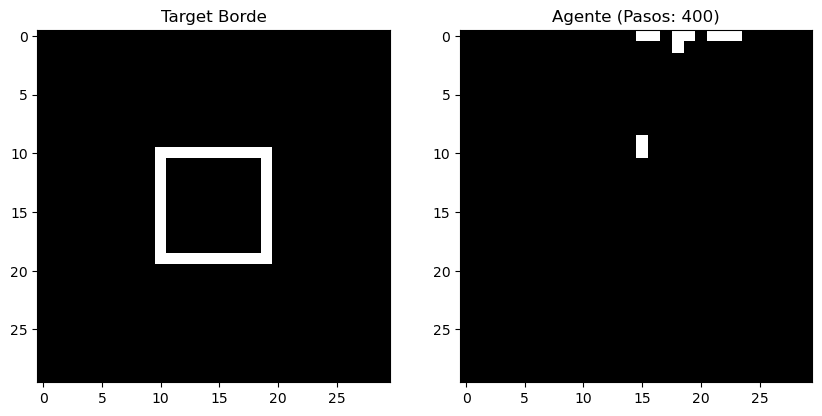

Mejor sim: 2.2% en ep 0
Mejor sim: 3.6% en ep 36
Mejor sim: 5.0% en ep 46
Mejor sim: 9.3% en ep 56
Mejor sim: 11.1% en ep 114
Mejor sim: 11.6% en ep 121
Mejor sim: 12.8% en ep 123
Mejor sim: 13.3% en ep 135
Mejor sim: 14.6% en ep 144
Mejor sim: 16.3% en ep 152
Mejor sim: 18.4% en ep 253
Mejor sim: 20.0% en ep 488
Mejor sim: 20.5% en ep 533
Mejor sim: 21.1% en ep 542
Mejor sim: 22.2% en ep 549
Mejor sim: 23.7% en ep 641
Mejor sim: 24.3% en ep 726
Mejor sim: 25.0% en ep 774
Mejor sim: 27.0% en ep 2347
Mejor sim: 27.8% en ep 2359
Mejor sim: 28.9% en ep 3770
Mejor sim: 29.7% en ep 3773
Mejor sim: 30.6% en ep 3805
Mejor sim: 31.6% en ep 4823
Mejor sim: 33.3% en ep 4824
Mejor sim: 35.1% en ep 5576
Mejor sim: 36.1% en ep 5603
Mejor sim: 38.9% en ep 6794
Mejor sim: 40.5% en ep 7594
Mejor sim: 41.7% en ep 7801
Mejor sim: 42.1% en ep 9523
Mejor sim: 43.2% en ep 9532
Mejor sim: 44.4% en ep 9553
Ep 10000: Reward 954.17 (avg 2.39), Sim 39.0%, Pasos 400


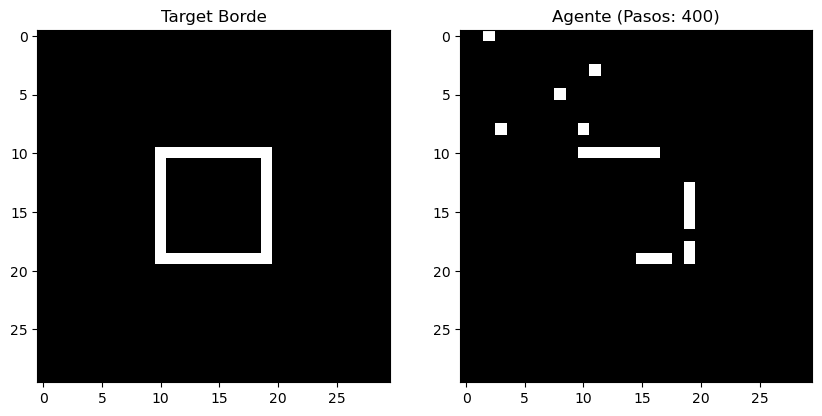

Mejor sim: 45.9% en ep 10768
Mejor sim: 47.2% en ep 10776
Mejor sim: 47.4% en ep 11913
Mejor sim: 50.0% en ep 12392
Mejor sim: 52.8% en ep 13819
Mejor sim: 54.1% en ep 15160
Mejor sim: 55.6% en ep 15387
Mejor sim: 58.3% en ep 16274
Mejor sim: 59.5% en ep 17647
Mejor sim: 61.1% en ep 17680
Mejor sim: 62.2% en ep 19239
Mejor sim: 63.9% en ep 19284
Ep 20000: Reward 1416.64 (avg 3.54), Sim 57.9%, Pasos 400


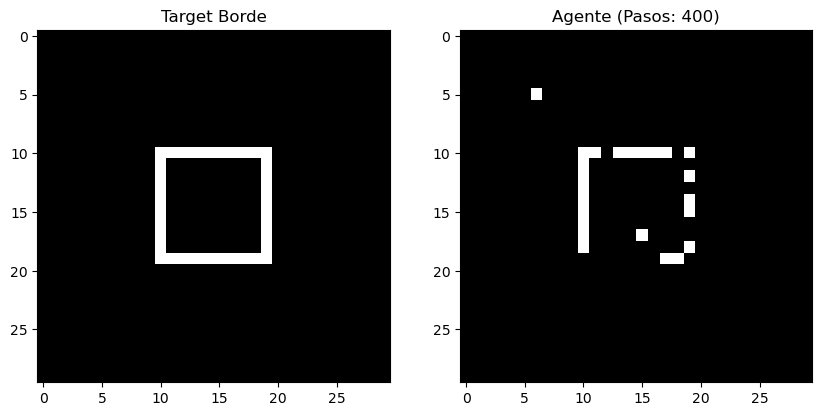

Mejor sim: 64.9% en ep 20756
Mejor sim: 66.7% en ep 20767
Mejor sim: 67.6% en ep 22551
Mejor sim: 69.4% en ep 22585
Mejor sim: 72.2% en ep 24238
Mejor sim: 75.0% en ep 27683
Ep 30000: Reward 1771.78 (avg 4.43), Sim 72.2%, Pasos 400


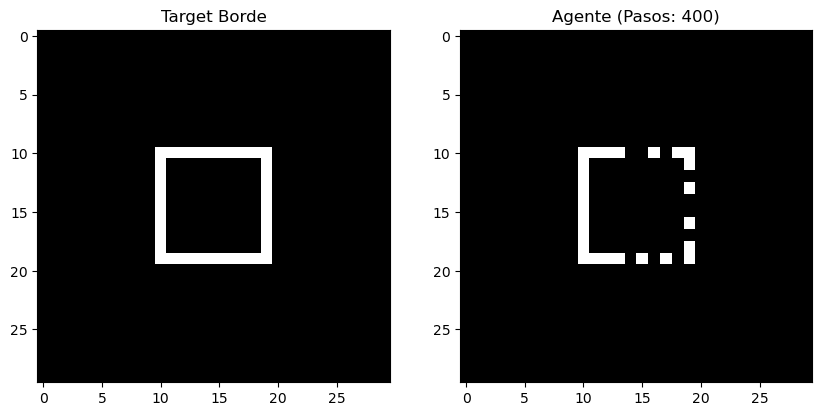

Mejor sim: 77.8% en ep 31050
Ep 40000: Reward 716.19 (avg 8.84), Sim 75.7%, Pasos 81


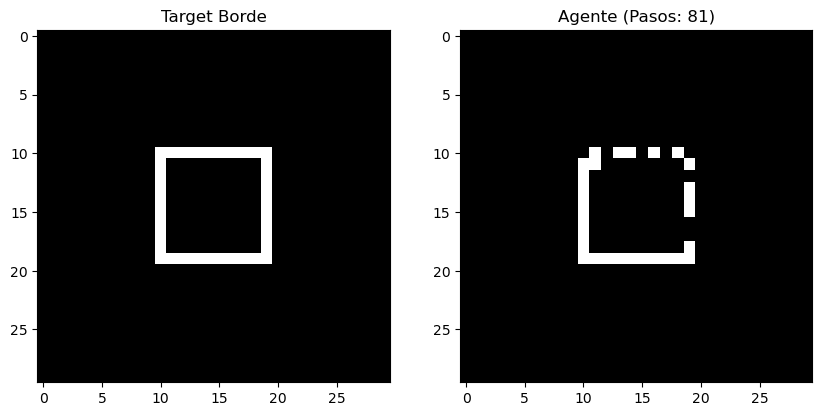

Ep 50000: Reward 1544.56 (avg 3.86), Sim 67.5%, Pasos 400


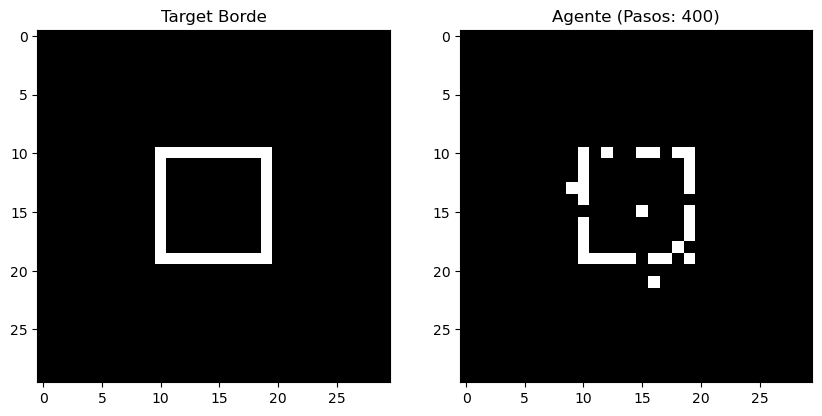

Ep 60000: Reward 1607.15 (avg 4.02), Sim 64.9%, Pasos 400


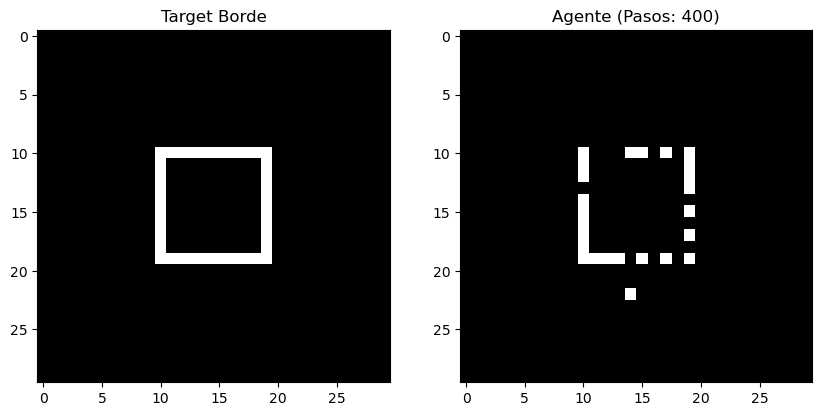

Early stopping en ep 66050: No mejora en 35000 eps. Mejor: 77.8% en ep 31050


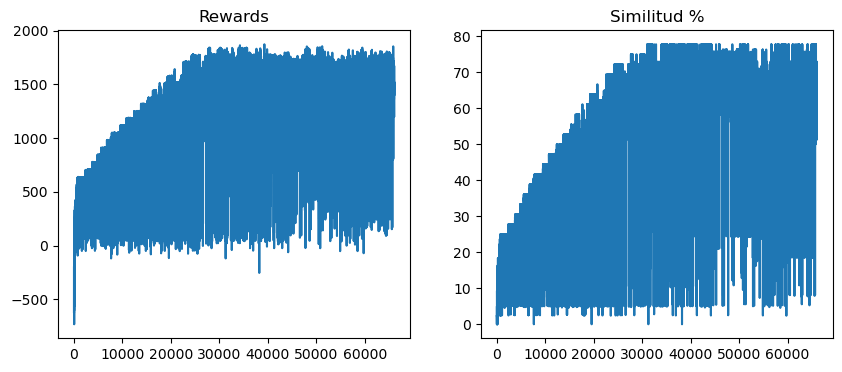

Mejor reward: 801.21 en ep 31050 (sim 77.8%)
Guardado BEST: q_best_cuadrado_borde.pkl
cuadrado_borde listo (sim 59.5%)


In [37]:
# Tu código actual (sin cambios)
def entrenar(agente, lienzo, fig, episodios=EPISODIOS, patience=PATIENCE):
    rewards = []
    sims = []
    best_sim = 0
    best_epoch = 0
    best_reward = 0
    no_improve_count = 0
    best_q = None

    for ep in range(episodios):
        current_epsilon = max(EPSILON_MIN, EPSILON_INITIAL - DECAY_RATE * ep)
        state = lienzo.reset()
        total_r = 0
        done = False
        while not done:
            action = agente.elegir_accion(state, current_epsilon)
            next_state, r, done = lienzo.step(action, fig)
            agente.update(state, action, r, next_state, done)
            state = next_state
            total_r += r
        sim = fig.similitud(lienzo.canvas)
        rewards.append(total_r)
        sims.append(sim)

        if ep % 10000 == 0:
            avg_r = total_r / lienzo.step_count if lienzo.step_count > 0 else 0
            print(f"Ep {ep}: Reward {total_r:.2f} (avg {avg_r:.2f}), Sim {sim:.1f}%, Pasos {lienzo.step_count}")
            lienzo.render_comparison(fig)

        if sim > best_sim:
            best_sim = sim
            best_epoch = ep
            best_reward = total_r
            no_improve_count = 0
            best_q = dict(agente.q_table.copy())
            print(f"Mejor sim: {best_sim:.1f}% en ep {ep}")
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                print(f"Early stopping en ep {ep}: No mejora en {patience} eps. Mejor: {best_sim:.1f}% en ep {best_epoch}")
                break

        if sim > 85:
            print(f"¡Aprendido en {ep}! (Mejor reward: {best_reward:.2f})")
            break

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.plot(rewards); plt.title('Rewards')
    plt.subplot(1,2,2); plt.plot(sims); plt.title('Similitud %')
    plt.show()

    print(f"Mejor reward: {best_reward:.2f} en ep {best_epoch} (sim {best_sim:.1f}%)")
    if best_q is not None:
        agente.guardar_best(best_q, fig.nombre)
    return sims[-1]

# Manual
fig = Figura()
fig.generar_borde_cuadrado()  # <--- CAMBIA
lienzo = Lienzo()
agente = Agente()
final_sim = entrenar(agente, lienzo, fig, patience=PATIENCE)
print(f"{fig.nombre} listo (sim {final_sim:.1f}%)")

Cargado BEST: q_best_cuadrado_borde.pkl


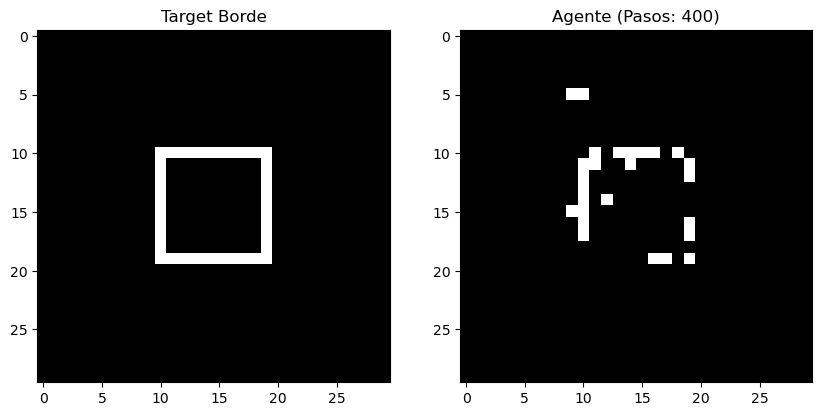

cuadrado_borde: Sim 47.6%, Pasos 400


In [38]:
# Tu código actual (sin cambios)
def dibujar_aprendida(nombre):
    agente = Agente()
    agente.cargar_best(nombre)  # Usa best si existe
    fig = Figura()
    if 'circulo' in nombre:
        fig.generar_borde_circulo()
    elif 'cuadrado' in nombre:
        fig.generar_borde_cuadrado()
    elif 'triangulo' in nombre:
        fig.generar_borde_triangulo()
    elif 'rectangulo' in nombre:
        fig.generar_borde_rectangulo()
    elif 'linea' in nombre:
        fig.generar_borde_linea()
    lienzo = Lienzo()
    state = lienzo.reset()
    done = False
    while not done and lienzo.step_count < MAX_STEPS:
        action = agente.elegir_accion(state)
        next_state, _, done = lienzo.step(action, fig)
        state = next_state
    sim = fig.similitud(lienzo.canvas)
    lienzo.render_comparison(fig)
    print(f"{nombre}: Sim {sim:.1f}%, Pasos {lienzo.step_count}")

dibujar_aprendida('cuadrado_borde')  # Cambia nombre

Cargado BEST: q_best_cuadrado_borde.pkl
Cargado sub-Q for cuadrado_borde
Cargado BEST: q_best_triangulo_borde.pkl
Cargado sub-Q for triangulo_borde
Ep 0 (['cuadrado_borde', 'triangulo_borde']): Sim total 9.8%, Pasos 400
Ep 50 (['cuadrado_borde', 'triangulo_borde']): Sim total 0.0%, Pasos 400
Ep 100 (['cuadrado_borde', 'triangulo_borde']): Sim total 9.4%, Pasos 400
Ep 150 (['cuadrado_borde', 'triangulo_borde']): Sim total 0.0%, Pasos 400
Ep 200 (['cuadrado_borde', 'triangulo_borde']): Sim total 0.0%, Pasos 400
Ep 250 (['cuadrado_borde', 'triangulo_borde']): Sim total 15.4%, Pasos 400
Ep 300 (['cuadrado_borde', 'triangulo_borde']): Sim total 0.0%, Pasos 400
Ep 350 (['cuadrado_borde', 'triangulo_borde']): Sim total 0.0%, Pasos 400
Ep 400 (['cuadrado_borde', 'triangulo_borde']): Sim total 0.0%, Pasos 400
Ep 450 (['cuadrado_borde', 'triangulo_borde']): Sim total 0.0%, Pasos 400


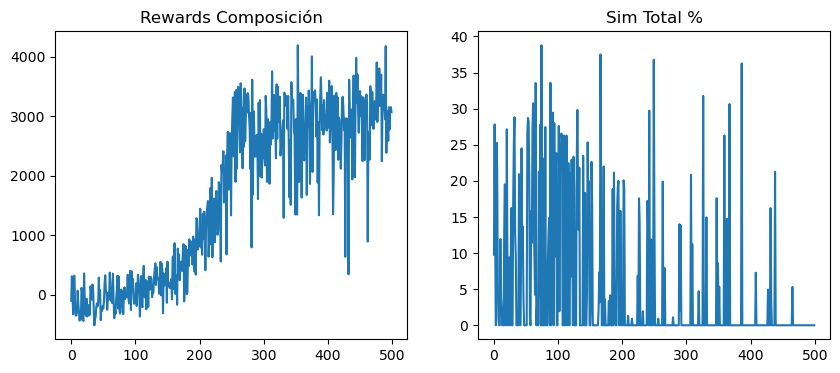

Guardado: q_cuadrado_borde_compuesto.pkl
No modelo; entrena.
Cargado BEST: q_best_cuadrado_borde.pkl
Cargado sub-Q for cuadrado_borde
Cargado BEST: q_best_triangulo_borde.pkl
Cargado sub-Q for triangulo_borde


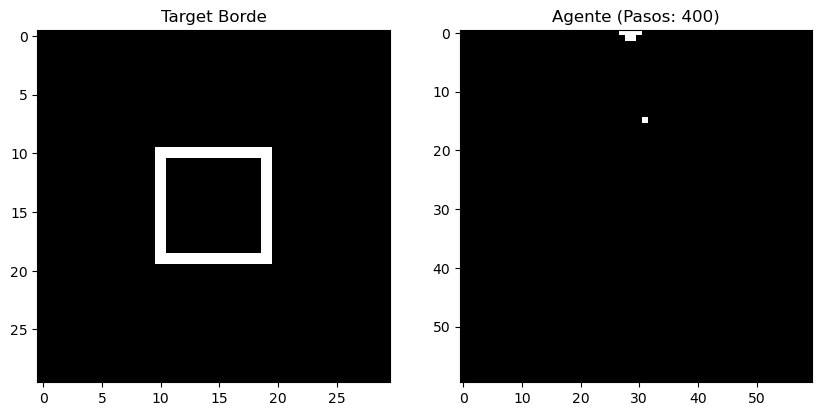

casa: Sim total 0.0%
Composiciones automáticas listas.


In [39]:
# Nuevo: MetaAgente para composiciones (extiende Agente)
class MetaAgente(Agente):
    def __init__(self, n_actions=N_ACTIONS + 3):  # +3 modos (cambio figura, máx 3 en receta)
        super().__init__(n_actions)
        self.sub_q = {}  # Diccionario Q individuales para modos

    def cambiar_modo(self, modo):
        self.sub_q[modo] = {}

    def cargar_sub(self, modo):
        sub_ag = Agente()
        sub_ag.cargar_best(modo)  # Usa BEST Q-table
        self.sub_q[modo] = sub_ag.q_table  # Copia Q-sub

    def elegir_accion(self, state, modo_actual, epsilon=EPSILON_INITIAL):
        if random.uniform(0, 1) < epsilon:
            return random.randint(0, self.n_actions - 1)
        if modo_actual == 'none':  # Modo cambio
            return np.argmax(self.q_table[state])
        else:
            sub_state = state
            if modo_actual in self.sub_q and sub_state in self.sub_q[modo_actual]:  # Nuevo: Check si loaded
                return np.argmax(self.sub_q[modo_actual][sub_state])
            else:
                return np.argmax(self.q_table[state])  # Fallback a Q-meta si no loaded (fix KeyError)

# Nuevo: Entrena meta para receta (aprende orden/posiciones)
def entrenar_compuesto(meta_agente, lienzo_grande, receta, episodios=500):
    fig_parts = [Figura() for _ in receta]
    for i, nom in enumerate(receta):
        if 'circulo' in nom:
            fig_parts[i].generar_borde_circulo()
        elif 'cuadrado' in nom:
            fig_parts[i].generar_borde_cuadrado()
        elif 'triangulo' in nom:
            fig_parts[i].generar_borde_triangulo()
        elif 'rectangulo' in nom:
            fig_parts[i].generar_borde_rectangulo()
        elif 'linea' in nom:
            fig_parts[i].generar_borde_linea()

    # Nuevo: Carga todas sub-Q al inicio (fix carga temprana)
    for nom in receta:
        meta_agente.cargar_sub(nom)
        print(f"Cargado sub-Q for {nom}")

    # Target compuesto inicial (overlay con offsets fijos; agente aprende mejores)
    target_comp = np.zeros((COMP_GRID_SIZE, COMP_GRID_SIZE))
    offsets = [(0,0), (0,10), (10,0)]  # Inicial; agente aprende
    for i, fig_part in enumerate(fig_parts):
        off = offsets[i % len(offsets)]
        target_comp[off[0]:off[0]+GRID_SIZE, off[1]:off[1]+GRID_SIZE] += fig_part.target

    rewards = []
    sims = []
    for ep in range(episodios):
        current_epsilon = max(EPSILON_MIN, EPSILON_INITIAL - DECAY_RATE * ep)
        state = lienzo_grande.reset()
        total_r = 0
        modo_actual = receta[0]  # Nuevo: Inicial primera figura (loaded)
        modo_idx = 0
        done = False
        while not done:
            action = meta_agente.elegir_accion(state, modo_actual, current_epsilon)
            if action >= N_ACTIONS:  # Cambio modo
                modo_idx = min(action - N_ACTIONS, len(receta) - 1)
                modo_actual = receta[modo_idx]
                reward = 0.5
            else:  # Dibujar/move
                next_state, r, done = lienzo_grande.step(action, fig_parts[modo_idx])
                reward = r
                partial_sim = fig_parts[modo_idx].similitud(lienzo_grande.canvas)
                if partial_sim > 50:
                    reward += 10
                    modo_idx = min(modo_idx + 1, len(receta) - 1)
                    modo_actual = receta[modo_idx] if modo_idx < len(receta) else 'none'
            meta_agente.update(state, action, reward, next_state if 'next_state' in locals() else state, done)
            state = next_state if 'next_state' in locals() else state
            total_r += reward

        sim_total = np.mean([f.similitud(lienzo_grande.canvas) for f in fig_parts])
        rewards.append(total_r)
        sims.append(sim_total)
        if ep % 50 == 0:
            print(f"Ep {ep} ({receta}): Sim total {sim_total:.1f}%, Pasos {lienzo_grande.step_count}")
        if sim_total > 80:
            break

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.plot(rewards); plt.title('Rewards Composición')
    plt.subplot(1,2,2); plt.plot(sims); plt.title('Sim Total %')
    plt.show()

    meta_agente.guardar(receta[0] + '_compuesto')  # Q-meta por receta
    return sims[-1]

# Nuevo: Dibuja composición (replay Q-meta)
def dibujar_compuesto(receta_nombre):
    meta_ag = MetaAgente(N_ACTIONS + 3)
    meta_ag.cargar_best(receta_nombre + '_compuesto')
    receta = RECETAS[receta_nombre]
    fig_parts = [Figura() for _ in receta]
    for i, nom in enumerate(receta):
        if 'circulo' in nom:
            fig_parts[i].generar_borde_circulo()
        elif 'cuadrado' in nom:
            fig_parts[i].generar_borde_cuadrado()
        elif 'triangulo' in nom:
            fig_parts[i].generar_borde_triangulo()
        elif 'rectangulo' in nom:
            fig_parts[i].generar_borde_rectangulo()
        elif 'linea' in nom:
            fig_parts[i].generar_borde_linea()

    # Nuevo: Carga todas sub-Q al inicio (fix para replay)
    for nom in receta:
        meta_ag.cargar_sub(nom)
        print(f"Cargado sub-Q for {nom}")

    lienzo_grande = Lienzo(COMP_GRID_SIZE)
    state = lienzo_grande.reset()
    done = False
    modo_idx = 0
    modo_actual = receta[0]  # Nuevo: Inicial primera (loaded)
    while not done and lienzo_grande.step_count < MAX_STEPS * 3:
        action = meta_ag.elegir_accion(state, modo_actual)
        if action >= N_ACTIONS:
            modo_idx = min(action - N_ACTIONS, len(receta) - 1)
            modo_actual = receta[modo_idx]
        else:
            next_state, _, done = lienzo_grande.step(action, fig_parts[modo_idx])
            state = next_state
            partial_sim = fig_parts[modo_idx].similitud(lienzo_grande.canvas)
            if partial_sim > 50:
                modo_idx = min(modo_idx + 1, len(receta) - 1)
                modo_actual = receta[modo_idx] if modo_idx < len(receta) else 'none'
    sim_total = np.mean([f.similitud(lienzo_grande.canvas) for f in fig_parts])
    lienzo_grande.render_comparison(fig_parts[0])  # Muestra compuesto
    print(f"{receta_nombre}: Sim total {sim_total:.1f}%")
    return lienzo_grande.canvas

# Uso: Entrena receta (una vez)
meta_ag = MetaAgente(N_ACTIONS + 3)
lienzo_grande = Lienzo(COMP_GRID_SIZE)
entrenar_compuesto(meta_ag, lienzo_grande, RECETAS['casa'])  # Ej: casa

# Dibuja
dibujar_compuesto('casa')
print("Composiciones automáticas listas.")